In [112]:
#pip install scikit-optimize

     ------------------------------------ 100.3/100.3 kB 957.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Load the required libraries

In [144]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Load the data from the cleaned data source file

In [2]:
#Load dataset into a pandas dataframe
data = pd.read_csv("../data/Cleaned data/data.csv") 

# don't really need to do this as this is cleaned data
data.dropna(inplace = True)

data.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,MIN,MAX,RAIN,SOLAR,RRP,FORECASTDEMAND,OUTPUT,MONTHDATE,WEEKDAY,WEEKEND,TEMPAVE
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,15.3,28.6,0.0,32.2,38.472917,6665.366167,23.465,01-2016,4,0,21.95
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,15.9,26.1,0.0,21.7,36.907292,6236.849955,23.465,01-2016,5,1,21.00
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,17.5,25.6,0.0,10.3,31.997083,6551.924748,23.465,01-2016,6,1,21.55
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,18.2,23.6,14.0,6.4,33.424583,6729.993123,23.465,01-2016,0,0,20.90
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,17.6,20.5,39.0,4.4,33.053958,7333.898202,23.465,01-2016,1,0,19.05


Drop the un-needed features

In [3]:
df = data.drop(['MIN','MAX','FORECASTDEMAND', 'MONTHDATE','WEEKEND','RAIN'], axis=1)

df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,WEEKDAY,TEMPAVE
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,32.2,38.472917,23.465,4,21.95
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,21.7,36.907292,23.465,5,21.00
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,10.3,31.997083,23.465,6,21.55
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,6.4,33.424583,23.465,0,20.90
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,4.4,33.053958,23.465,1,19.05


One-hot encoding of categorical variables

In [4]:
# One-hot Encoding for categorial data (Weekday)

# Select the "WEEKDAY" column and create a new dataframe
weekday_df = df[['WEEKDAY']]

# Create a one-hot encoder object
encoder = OneHotEncoder(categories='auto')

# Fit and transform the weekday data
weekday_encoded = encoder.fit_transform(df[['WEEKDAY']]).toarray()

# Create a new dataframe with the encoded weekday data
weekday_df = pd.DataFrame(weekday_encoded, columns=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])

#Drop the weekday column
df = df.drop(['WEEKDAY'], axis=1)

# Concatenate the original dataframe with the encoded weekday dataframe
df = pd.concat([df, weekday_df], axis=1)

df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,TEMPAVE,MON,TUE,WED,THU,FRI,SAT,SUN
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,32.2,38.472917,23.465,21.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,21.7,36.907292,23.465,21.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,10.3,31.997083,23.465,21.55,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,6.4,33.424583,23.465,20.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,4.4,33.053958,23.465,19.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Convert the 'date' column to a datetime object
df['DATE'] = pd.to_datetime(df['DATE'])

# Set 'DATE' as the index
df.set_index('DATE', inplace=True)

In [6]:
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,TEMPAVE,MON,TUE,WED,THU,FRI,SAT,SUN
DATE,,,,,,,,,,,,,,,,,,
2016-01-01,2016,1,1,0.656341,15.902439,6853.633437,2.0,32.2,38.472917,23.465,21.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-01-02,2016,1,2,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,23.465,21.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-01-03,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,23.465,21.55,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-01-04,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,23.465,20.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-05,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,23.465,19.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28,2022,7,28,0.570217,21.608696,8712.672500,0.0,12.8,114.477308,183.255,12.95,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-07-29,2022,7,29,0.594186,16.209302,8850.636146,0.0,13.0,109.037174,183.255,11.80,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-07-30,2022,7,30,0.585238,24.642857,8601.131632,0.0,13.1,74.349286,183.255,10.15,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Split the dataset into training and testing sets
<br>Note: 
- training is from August 2017 - July 2021 (inclusive)
- testing is from August 2021 - July 2022 (inclusive) 

In [7]:
train_set = np.where((df.index >= datetime(2017, 8, 1)) & (df.index < datetime(2021, 8, 1)))[0]
test_set = np.where(df.index >= datetime(2021, 8, 1))[0]

# identify response variable and predictors
X = df.drop(['TOTALDEMAND'], axis=1).values
y = df['TOTALDEMAND'].values

print("number of training records",len(train_set))
print("number of test records",len(test_set))

1461
337
337


Normalize the data

In [8]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X[train_set])
X_test_scaled = scaler_X.transform(X[test_set])

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y[train_set].reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y[test_set].reshape(-1, 1)).ravel()

print(X_train_scaled[:5])
print(len(X_train_scaled))
print(len(X_test_scaled))

[[0.         0.63636364 0.         0.5780574  0.48699955 0.
  0.4068323  0.7116133  0.10793701 0.32412791 0.         1.
  0.         0.         0.         0.         0.        ]
 [0.         0.63636364 0.03333333 0.5780574  0.48699955 0.
  0.40372671 0.64976244 0.10793701 0.3255814  0.         0.
  1.         0.         0.         0.         0.        ]
 [0.         0.63636364 0.06666667 0.69542214 0.28363047 0.
  0.2826087  0.749493   0.10793701 0.39244186 0.         0.
  0.         1.         0.         0.         0.        ]
 [0.         0.63636364 0.1        0.87136016 0.12704281 0.
  0.41304348 0.68692824 0.10793701 0.35901163 0.         0.
  0.         0.         1.         0.         0.        ]
 [0.         0.63636364 0.13333333 0.52090236 0.44853191 0.
  0.42857143 0.55983012 0.10793701 0.34302326 0.         0.
  0.         0.         0.         1.         0.        ]]
1461
337


Reshape the data for input to the LSTM model 
(Note: we are using the scikit-optimize library) 

In [199]:
#(This step will fit the data to a 3D tensor format for the LSTM model to process the sequential data efficiently 
#and capture any temporal dependencies in the data)

#we using sliding window approach to create input-output pairs with
#timesteps n = 1

X_train = []
y_train = []
for i in range(1, len(X_train_scaled)):
    X_train.append(X_train_scaled[i-1:i, :])
    y_train.append(X_train_scaled[i, 1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

X_test = []
y_test = []
for i in range(1, len(X_test_scaled)):
    X_test.append(X_test_scaled[i-1:i, :])
    y_test.append(X_test_scaled[i, 1])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))

y_test

array([0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.81818182, 0.81818182, 0.81818182, 0.81818182, 0.81818182,
       0.81818182, 0.81818182, 0.81818182, 0.81818182, 0.81818182,
       0.81818182, 0.81818182, 0.81818182, 0.81818182, 0.81818

We use a Bayesian optimisation process to find the optimum combination of hyperparameters for this model

In [217]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from skopt import gp_minimize
# from skopt.space import Real, Integer, Space, Categorical
# from skopt.utils import use_named_args

# # Setting the input and output dimensions and timesteps for the forecast
# input_dim = X_train.shape[2]
# output_dim = 1
# timesteps = 1

# # Assuming X_train and X_test are numpy arrays
# X_train = X_train.reshape((X_train.shape[0], timesteps, input_dim))
# X_test = X_test.reshape((X_test.shape[0], timesteps, input_dim))

# # Define a function to create the LSTM model
# def create_lstm_model(lr, n_units, dropout_rate1, dropout_rate2, dropout_rate3, activation1, activation2, activation3):
#     model = Sequential()
#     model.add(LSTM(units=n_units, input_shape=(timesteps, input_dim), return_sequences=True, activation=activation1))
#     model.add(Dropout(dropout_rate1))
#     model.add(LSTM(units=n_units, activation=activation2, return_sequences=True))
#     model.add(Dropout(dropout_rate2))
#     model.add(LSTM(units=n_units, activation=activation3))
#     model.add(Dropout(dropout_rate3))
#     model.add(Dense(output_dim))

#     optimizer = Adam(learning_rate=lr)
#     model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
#     return model

# # Define the function to optimize
# @use_named_args([
#     Real(1e-5, 1e-2, "log-uniform", name='learning_rate'),
#     Integer(64, 1024, name='n_units'),
#     Real(0.0, 0.5, name='dropout_rate1'),
#     Real(0.0, 0.5, name='dropout_rate2'),
#     Real(0.0, 0.5, name='dropout_rate3'),
#     Categorical(['tanh', 'relu', 'sigmoid'], name='activation1'),
#     Categorical(['tanh', 'relu', 'sigmoid'], name='activation2'),
#     Categorical(['tanh', 'relu', 'sigmoid'], name='activation3')
# ])

# def optimize_lstm(learning_rate, n_units, 
#                   dropout_rate1, dropout_rate2, dropout_rate3, 
#                   activation1, activation2, activation3):
#     # Create the model
#     model = create_lstm_model(learning_rate, n_units, 
#                               dropout_rate1, dropout_rate2, dropout_rate3, 
#                               activation1, activation2, activation3)
    
#     # Train the model
#     history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
#                         epochs=50, batch_size=64, verbose=0, callbacks=[early_stopping])
    
#     # Get the validation MAE from the last epoch
#     val_mae = history.history['val_mae'][-1]
    
#     return val_mae

# # Set up early stopping to prevent overfitting
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# # Define the search space
# search_space = Space([
#     Real(1e-5, 1e-2, "log-uniform", name='learning_rate'),
#     Integer(64, 1024, name='n_units'),
#     Real(0.0, 0.5, name='dropout_rate1'),
#     Real(0.0, 0.5, name='dropout_rate2'),
#     Real(0.0, 0.5, name='dropout_rate3'),
#     Categorical(['tanh', 'relu', 'sigmoid'], name='activation1'),
#     Categorical(['tanh', 'relu', 'sigmoid'], name='activation2'),
#     Categorical(['tanh', 'relu', 'sigmoid'], name='activation3')
# ])

# # Run the Bayesian optimization
# result = gp_minimize(optimize_lstm, search_space, n_calls=50, random_state=42)

# extract the best hyperparameters
best_learning_rate, best_n_units, best_dropout_rate1, best_dropout_rate2, best_dropout_rate3, best_activation1, best_activation2, best_activation3 = result.x

In [218]:
# Print the optimal hyperparameters
print(f"Best learning rate: {best_learning_rate}")
print(f"Best number of LSTM units: {best_n_units}")
print(f"Best activation1 rate: {best_activation1}")
print(f"Best activation2 rate: {best_activation2}")
print(f"Best activation3 rate: {best_activation3}")
print(f"Best dropout1 rate: {best_dropout_rate1}")
print(f"Best dropout2 rate: {best_dropout_rate2}")
print(f"Best dropout3 rate: {best_dropout_rate3}")


Best learning rate: 0.0001145750512352549
Best number of LSTM units: 1024
Best activation1 rate: relu
Best activation2 rate: tanh
Best activation3 rate: relu
Best dropout1 rate: 0.5
Best dropout2 rate: 0.0
Best dropout3 rate: 0.0


Build the final LSTM model with the optimal hyperparameters selected

In [219]:
# setup the model 
timesteps=X_train.shape[1]
input_dim=X_train.shape[2]
output_dim=1

# Build the LSTM model with 1 input layer, 2 hidden LSTM layers and one Dense output layer
# using the best combination of hyperparameters as derived above
model = Sequential()
model.add(LSTM(units=best_n_units, input_shape=(timesteps, input_dim), return_sequences=True, activation=best_activation1))
model.add(Dropout(best_dropout_rate1))
model.add(LSTM(units=best_n_units, activation=best_activation2, return_sequences=True))
model.add(Dropout(best_dropout_rate2))
model.add(LSTM(units=best_n_units, activation=best_activation3))
model.add(Dropout(best_dropout_rate3))
model.add(Dense(output_dim))

optimizer=Adam(learning_rate=best_learning_rate)
model.compile(loss='mae', optimizer=optimizer)

In [220]:
#set the model to stop early if it appears to converge (decided on 20 iterations with no changes)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20) 

# Train the LSTM model on the olptimum model definition
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/50
23/23 [==============================] - 10s 145ms/step - loss: 0.4816 - val_loss: 0.4384
Epoch 2/50
23/23 [==============================] - 2s 101ms/step - loss: 0.3507 - val_loss: 0.2896
Epoch 3/50
23/23 [==============================] - 2s 101ms/step - loss: 0.2503 - val_loss: 0.2632
Epoch 4/50
23/23 [==============================] - 2s 104ms/step - loss: 0.2121 - val_loss: 0.2267
Epoch 5/50
23/23 [==============================] - 2s 104ms/step - loss: 0.1620 - val_loss: 0.1661
Epoch 6/50
23/23 [==============================] - 2s 106ms/step - loss: 0.1016 - val_loss: 0.0976
Epoch 7/50
23/23 [==============================] - 2s 102ms/step - loss: 0.0643 - val_loss: 0.0415
Epoch 8/50
23/23 [==============================] - 2s 101ms/step - loss: 0.0509 - val_loss: 0.0300
Epoch 9/50
23/23 [==============================] - 2s 107ms/step - loss: 0.0455 - val_loss: 0.0300
Epoch 10/50
23/23 [==============================] - 3s 110ms/step - loss: 0.0420 - val_loss: 0.024

Run the prediction on the test set

In [221]:
# Make predictions on the test set
y_pred = model.predict(X_test)


11/11 [==============================] - 1s 13ms/step


In [222]:
# Evaluate the LSTM model on the test set
# Calculate MAE, MSE and R-squared

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE: %.4f' % mae)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % r2)

MAE: 0.0213
MSE: 0.0035
R-squared: 0.9673


Plot the loss function (MAE) against the training and test data 

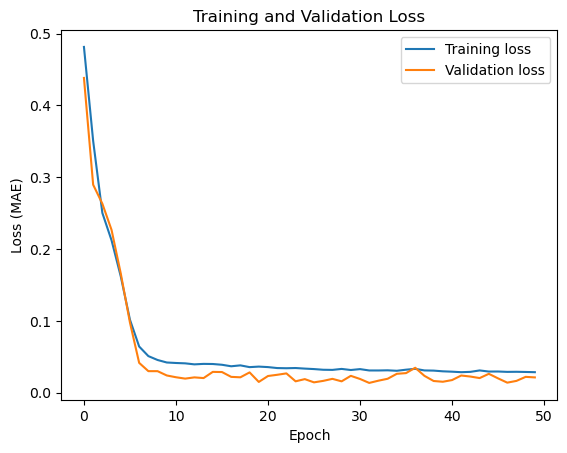

In [223]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

# Plot training and validation loss (MAE) for each epoch
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()




Plot Accuracy

In [24]:

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt



In [182]:
y_test

array([0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.81818182, 0.81818182, 0.81818182, 0.81818182, 0.81818182,
       0.81818182, 0.81818182, 0.81818182, 0.81818182, 0.81818182,
       0.81818182, 0.81818182, 0.81818182, 0.81818182, 0.81818

In [25]:
data["FORECASTDEMAND"]

0       6665.366167
1       6236.849955
2       6551.924748
3       6729.993123
4       7333.898202
           ...     
2371    8782.902714
2372    9082.919122
2373    8721.769989
2374    8602.762027
2375    8231.479437
Name: FORECASTDEMAND, Length: 2376, dtype: float64

In [1003]:
X_all

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,HOLIDAY,SOLAR,RRP,OUTPUT,TEMPAVE,MON,TUE,WED,THU,FRI,SAT,SUN
DATE,,,,,,,,,,,,,,,,,
2016-01-01,2016,1,1,0.656341,15.902439,2.0,32.2,38.472917,23.465,21.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-01-02,2016,1,2,0.656341,15.902439,0.0,21.7,36.907292,23.465,21.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-01-03,2016,1,3,0.688837,14.488372,0.0,10.3,31.997083,23.465,21.55,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-01-04,2016,1,4,0.679545,22.477273,0.0,6.4,33.424583,23.465,20.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-05,2016,1,5,0.768837,22.581395,0.0,4.4,33.053958,23.465,19.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28,2022,7,28,0.570217,21.608696,0.0,12.8,114.477308,183.255,12.95,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-07-29,2022,7,29,0.594186,16.209302,0.0,13.0,109.037174,183.255,11.80,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-07-30,2022,7,30,0.585238,24.642857,0.0,13.1,74.349286,183.255,10.15,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [63]:
# Create df_lim
df_lim = pd.DataFrame()
df_lim["DATE"] = pd.to_datetime(dict(year=df.YEAR, month=df.MONTH, day=df.DAY))
df_lim["TOTALDEMAND"] = df["TOTALDEMAND"]
df_lim["YTEST"] = y_test_scaled
df_lim["YPRED"] = y_pred.reshape(-1)
df_lim["FORECAST"] = df["FORECASTDEMAND"].tail(test_len).shift(-1).replace(0, np.nan)

# Drop missing values
df_lim = df_lim.dropna()

# Set DATE as index
df_lim.set_index('DATE', inplace=True)

# Plot demand and forecast demand
fig, ax = plt.subplots(figsize=(20,5))
demand = ax.plot(df_lim.index, df_lim["TOTALDEMAND"], linewidth=1, color='blue')
forecast_demand = ax.plot(df_lim.index, df_lim["FORECAST"], linewidth=1, color='red')
ax.legend([demand, forecast_demand], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Demand vs Forecast Demand")
plt.show()

# Inverse transform the scaled values of y_test
y_test_inverse = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

# Inverse transform the scaled values of y_pred
y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()

# Plot the actual and predicted values
fig, ax = plt.subplots(figsize=(20,5))
demand = ax.plot(df_lim['DATE'], df_lim['TOTALDEMAND'], linewidth=1, color='blue')
forecast = ax.plot(df_lim['DATE'], df_lim['FORECAST'], linewidth=1, color='red')
test = ax.plot(df_lim['DATE'], y_test_inverse, linewidth=1, color='green')
pred = ax.plot(df_lim['DATE'], y_pred_inverse, linewidth=1, color='orange')
ax.legend([demand, forecast, test, pred], labels=["Demand", "Forecast Demand", "Actual Demand", "Predicted Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Actual and Predicted Demand")
plt.show()

ValueError: Length of values (337) does not match length of index (2376)

In [1006]:

df_lim = df.tail(test_len-1).copy()

df_lim.columns = df.columns

df_lim["YTEST"] = y_test
df_lim["YPRED"] = y_pred
df_lim["DATE"] = pd.to_datetime(dict(year=df.YEAR, month=df.MONTH, day=df.DAY))
df_lim["FORECAST"] = data["FORECASTDEMAND"].tail(test_len).shift(-1).replace(0, np.nan)
df_lim = df_lim.dropna()
df_lim = df_lim[["DATE","TOTALDEMAND","YTEST","YPRED","FORECAST"]]
df_lim = df_lim.iloc[1:,:]

df_lim.head()

,DATE,TOTALDEMAND,YTEST,YPRED,FORECAST
DATE,,,,,


In [985]:
Date = [d.date() for d in df_lim.DATE]
Demand = df_lim.TOTALDEMAND
Forecast = df_lim.FORECAST
Pred = df_lim.YPRED
Test = df_lim.YTEST

<ipython-input-979-d61565150993>:4: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])


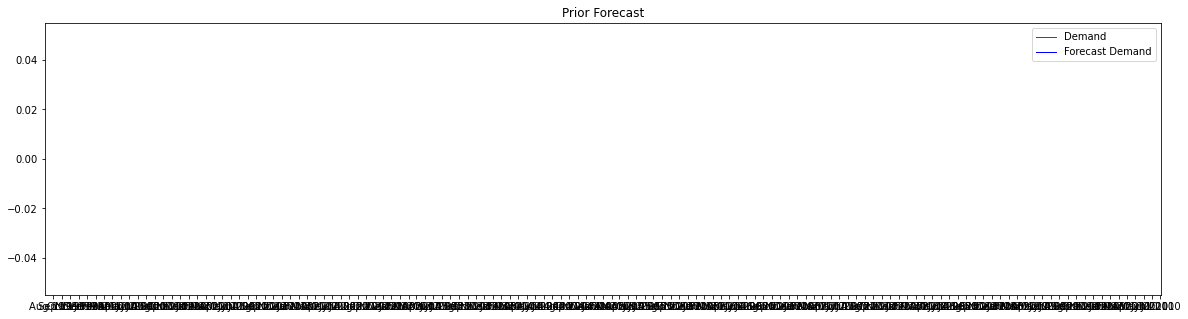

In [979]:
fig, ax = plt.subplots(figsize=(20,5))
forecast = ax.plot(Date, Forecast, linewidth=1, color='red')
test = ax.plot(Date, Test, linewidth=1, color='blue')
ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Prior Forecast")
plt.show()

In [609]:
# Print prior model performance of the data used

mae1 = mean_absolute_error(Test, Forecast)
mse1 = mean_squared_error(Test, Forecast)
rmse1 = np.sqrt(mse1)
print("Mean Absolute Error: {:.2f}".format(mae1))
print("Root Mean Squared Error: {:.2f}".format(rmse1))


fig, ax = plt.subplots(figsize=(20,5))
forecast = ax.plot(Date, Pred, linewidth=1, color='red')
test = ax.plot(Date, Test, linewidth=1, color='blue')
ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Current Forecast")
plt.show()

NameError: name 'mean_absolute_error' is not defined

In [610]:
# print this current model performance

mae2 = mean_absolute_error(Test, Pred)
mse2 = mean_squared_error(Test, Pred)
rmse2 = np.sqrt(mse2)

print("Mean Absolute Error: {:.2f}".format(mae2))
print("Root Mean Squared Error: {:.2f}".format(rmse2))

NameError: name 'mean_absolute_error' is not defined